In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.11.0+cu113 True


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-x3vntzdm
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-x3vntzdm
     |████████████████████████████████| 50 kB 3.0 MB/s 
     |████████████████████████████████| 74 kB 3.3 MB/s 
     |████████████████████████████████| 147 kB 46.6 MB/s 
     |████████████████████████████████| 130 kB 47.5 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 843 kB 33.3 MB/s 
     |████████████████████████████████| 749 kB 43.6 MB/s 
     |████████████████████████████████| 596 kB 45.4 MB/s 
     |████████████████████████████████| 112 kB 47.8 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5258267 sha256=d35b7676b7a08792291b4002650124203896fc3ba76b84ec2a43afdfeb5f672b
  Stored in directory: /tmp/pip-ephem-wheel-cache-xay7uni3/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional



from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch import transforms#ToTensorV2

from glob import glob
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json

with open('/content/drive/MyDrive/kvasir/bboxes.json') as f:
    bbox = json.load(f)

file_path=r'/content/drive/MyDrive/kvasir/test.txt'
path=r'kvasir'
# load_data(path,file_path)
f = open(file_path, "r")
train = f.read().split("\n")[:-1]
file_path=r'/content/drive/MyDrive/kvasir/test.txt'
path=r'kvasir'
# load_data(path,file_path)
f = open(file_path, "r")
test = f.read().split("\n")[:-1]
df=pd.DataFrame(test)
h=[]
w=[]
l=[]
xmin=[]
xmax=[]
ymin=[]
ymax=[]
for j in df[0]:
    h.append(bbox[j]['height'])
    w.append(bbox[j]['width'])
    l.append(bbox[j]['bbox'][0]['label'])
    xmin.append(bbox[j]['bbox'][0]['xmin'])
    xmax.append(bbox[j]['bbox'][0]['xmax'])
    ymin.append(bbox[j]['bbox'][0]['ymin'])
    ymax.append(bbox[j]['bbox'][0]['ymax'])
df['height']=h
df['width']=w
df['label']=l
df['xmin']=xmin
df['ymin']=ymin
df['xmax']=xmax
df['ymax']=ymax
df.rename(columns={0: 'filename'}, inplace=True)
test_df=df
test_df["filename"] = df["filename"]+".jpg"
test_df['filename']="/content/drive/MyDrive/kvasir/yuv/" +test_df['filename']
train_df=pd.DataFrame(train)
h=[]
w=[]
l=[]
xmin=[]
xmax=[]
ymin=[]
ymax=[]
for j in train_df[0]:
    h.append(bbox[j]['height'])
    w.append(bbox[j]['width'])
    l.append(bbox[j]['bbox'][0]['label'])
    xmin.append(bbox[j]['bbox'][0]['xmin'])
    xmax.append(bbox[j]['bbox'][0]['xmax'])
    ymin.append(bbox[j]['bbox'][0]['ymin'])
    ymax.append(bbox[j]['bbox'][0]['ymax'])

train_df['height']=h
train_df['width']=w
train_df['label']=l
train_df['xmin']=xmin
train_df['ymin']=ymin
train_df['xmax']=xmax
train_df['ymax']=ymax
train_df.rename(columns={0: 'image_id'}, inplace=True)
train_df["image"] = train_df["image_id"]+".jpg"
train_df['image_path']='/content/drive/MyDrive/kvasir/yuv/'+train_df['image']



In [ ]:
train_df.head()

image_id  height  width       label  xmin  ymin  xmax  \
0  ckd4ipizn000d3b5yk2vrbyyz     576    768  instrument   435    25   717   
1  ckcxct8oj000k3b5y9iwia72h     576    720  instrument   387   376   613   
2  ckd4ig3d700043b5y0p70afjj     576    720  instrument   238    11   427   
3  ckd03in4g001d3b5yngyc734r     576    768  instrument   396    26   524   
4  ckcx9nmko001u3b5yopeccdvo     576    720  instrument    90    17   431   

   ymax                          image  \
0   410  ckd4ipizn000d3b5yk2vrbyyz.jpg   
1   555  ckcxct8oj000k3b5y9iwia72h.jpg   
2   462  ckd4ig3d700043b5y0p70afjj.jpg   
3   318  ckd03in4g001d3b5yngyc734r.jpg   
4   195  ckcx9nmko001u3b5yopeccdvo.jpg   

                                          image_path  
0  /content/drive/MyDrive/kvasir/yuv/ckd4ipizn000...  
1  /content/drive/MyDrive/kvasir/yuv/ckcxct8oj000...  
2  /content/drive/MyDrive/kvasir/yuv/ckd4ig3d7000...  
3  /content/drive/MyDrive/kvasir/yuv/ckd03in4g001...  
4  /content/drive/MyDrive/kvasir/yuv/ckcx9nmko001...

In [ ]:
df_train=train_df.drop('label',axis=1)
df_train.head()

image_id  height  width  xmin  ymin  xmax  ymax  \
0  ckd4ipizn000d3b5yk2vrbyyz     576    768   435    25   717   410   
1  ckcxct8oj000k3b5y9iwia72h     576    720   387   376   613   555   
2  ckd4ig3d700043b5y0p70afjj     576    720   238    11   427   462   
3  ckd03in4g001d3b5yngyc734r     576    768   396    26   524   318   
4  ckcx9nmko001u3b5yopeccdvo     576    720    90    17   431   195   

                           image  \
0  ckd4ipizn000d3b5yk2vrbyyz.jpg   
1  ckcxct8oj000k3b5y9iwia72h.jpg   
2  ckd4ig3d700043b5y0p70afjj.jpg   
3  ckd03in4g001d3b5yngyc734r.jpg   
4  ckcx9nmko001u3b5yopeccdvo.jpg   

                                          image_path  
0  /content/drive/MyDrive/kvasir/yuv/ckd4ipizn000...  
1  /content/drive/MyDrive/kvasir/yuv/ckcxct8oj000...  
2  /content/drive/MyDrive/kvasir/yuv/ckd4ig3d7000...  
3  /content/drive/MyDrive/kvasir/yuv/ckd03in4g001...  
4  /content/drive/MyDrive/kvasir/yuv/ckcx9nmko001...

In [ ]:
x_min = df_train['xmin']
y_min = df_train['ymin']
x_max = df_train['xmax']
y_max = df_train['ymax']
bboxes = list()
for i in range(len(x_min)):
    bboxes.append([[x_min[i],y_min[i],x_max[i],y_max[i]]])
df_train['bboxes'] = bboxes
df_train.head()

image_id  height  width  xmin  ymin  xmax  ymax  \
0  ckd4ipizn000d3b5yk2vrbyyz     576    768   435    25   717   410   
1  ckcxct8oj000k3b5y9iwia72h     576    720   387   376   613   555   
2  ckd4ig3d700043b5y0p70afjj     576    720   238    11   427   462   
3  ckd03in4g001d3b5yngyc734r     576    768   396    26   524   318   
4  ckcx9nmko001u3b5yopeccdvo     576    720    90    17   431   195   

                           image  \
0  ckd4ipizn000d3b5yk2vrbyyz.jpg   
1  ckcxct8oj000k3b5y9iwia72h.jpg   
2  ckd4ig3d700043b5y0p70afjj.jpg   
3  ckd03in4g001d3b5yngyc734r.jpg   
4  ckcx9nmko001u3b5yopeccdvo.jpg   

                                          image_path                  bboxes  
0  /content/drive/MyDrive/kvasir/yuv/ckd4ipizn000...   [[435, 25, 717, 410]]  
1  /content/drive/MyDrive/kvasir/yuv/ckcxct8oj000...  [[387, 376, 613, 555]]  
2  /content/drive/MyDrive/kvasir/yuv/ckd4ig3d7000...   [[238, 11, 427, 462]]  
3  /content/drive/MyDrive/kvasir/yuv/ckd03in4g001...   [[396, 26, 524, 318]]  
4  /content/drive/MyDrive/kvasir/yuv/ckcx9nmko001...    [[90, 17, 431, 195]]

In [ ]:
# df=df_train
# df_train["Width"]=676
# df_train["Height"]=380
# df_train.sample(2)

In [ ]:
df_train.head()

image_id  height  width  xmin  ymin  xmax  ymax  \
0  ckd4ipizn000d3b5yk2vrbyyz     576    768   435    25   717   410   
1  ckcxct8oj000k3b5y9iwia72h     576    720   387   376   613   555   
2  ckd4ig3d700043b5y0p70afjj     576    720   238    11   427   462   
3  ckd03in4g001d3b5yngyc734r     576    768   396    26   524   318   
4  ckcx9nmko001u3b5yopeccdvo     576    720    90    17   431   195   

                           image  \
0  ckd4ipizn000d3b5yk2vrbyyz.jpg   
1  ckcxct8oj000k3b5y9iwia72h.jpg   
2  ckd4ig3d700043b5y0p70afjj.jpg   
3  ckd03in4g001d3b5yngyc734r.jpg   
4  ckcx9nmko001u3b5yopeccdvo.jpg   

                                          image_path                  bboxes  
0  /content/drive/MyDrive/kvasir/yuv/ckd4ipizn000...   [[435, 25, 717, 410]]  
1  /content/drive/MyDrive/kvasir/yuv/ckcxct8oj000...  [[387, 376, 613, 555]]  
2  /content/drive/MyDrive/kvasir/yuv/ckd4ig3d7000...   [[238, 11, 427, 462]]  
3  /content/drive/MyDrive/kvasir/yuv/ckd03in4g001...   [[396, 26, 524, 318]]  
4  /content/drive/MyDrive/kvasir/yuv/ckcx9nmko001...    [[90, 17, 431, 195]]

In [ ]:
n_spl=3
Selected_Fold=2 #0..2

from sklearn.model_selection import GroupKFold
gkf  = GroupKFold(n_splits = n_spl) # num_folds=3 as there are total 3 videos
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df_train, groups = df_train.image_id.tolist())):
    df_train.loc[val_idx, 'fold'] = fold
display(df_train.fold.value_counts())

0    40
1    39
2    39
Name: fold, dtype: int64

In [ ]:
def get_data_dicts(
    _train_df: pd.DataFrame,
    debug: bool = False,
    data_type:str="train"

):

    if debug:
        _train_df = _train_df.iloc[:10]  # For debug...
    dataset_dicts = []
    if data_type=="train":
        _train_df=_train_df[_train_df.fold != Selected_Fold]
    else: # val
        _train_df=_train_df[_train_df.fold == Selected_Fold]

    for index, row in tqdm(_train_df.iterrows(), total=len(_train_df)):
        record = {}
        filename  = row.image_path #filename = str(f'{imgdir}/{image_id}.png')
        image_id = row.image_id
        image_height= row.height
        image_width = row.width
        bboxes_coco = row.bboxes
        #bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
        record["file_name"] = filename
        record["image_id"] = image_id
        record["width"] = image_width
        record["height"] = image_height
        objs = []
        class_id = 0
        for bbox_idx in range(len(bboxes_coco)):
            bbox=bboxes_coco[bbox_idx]
            obj = {
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                }
            objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [ ]:
thing_classes=['instrument']
debug=False

Data_Resister_training="BR_data_train2";
Data_Resister_valid="BR_data_valid2";


DatasetCatalog.register(
    Data_Resister_training,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="train"
    ),
)
MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)


DatasetCatalog.register(
    Data_Resister_valid,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="val"
        ),
    )
MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)


dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)

100%|██████████| 39/39 [00:00<00:00, 6599.87it/s]


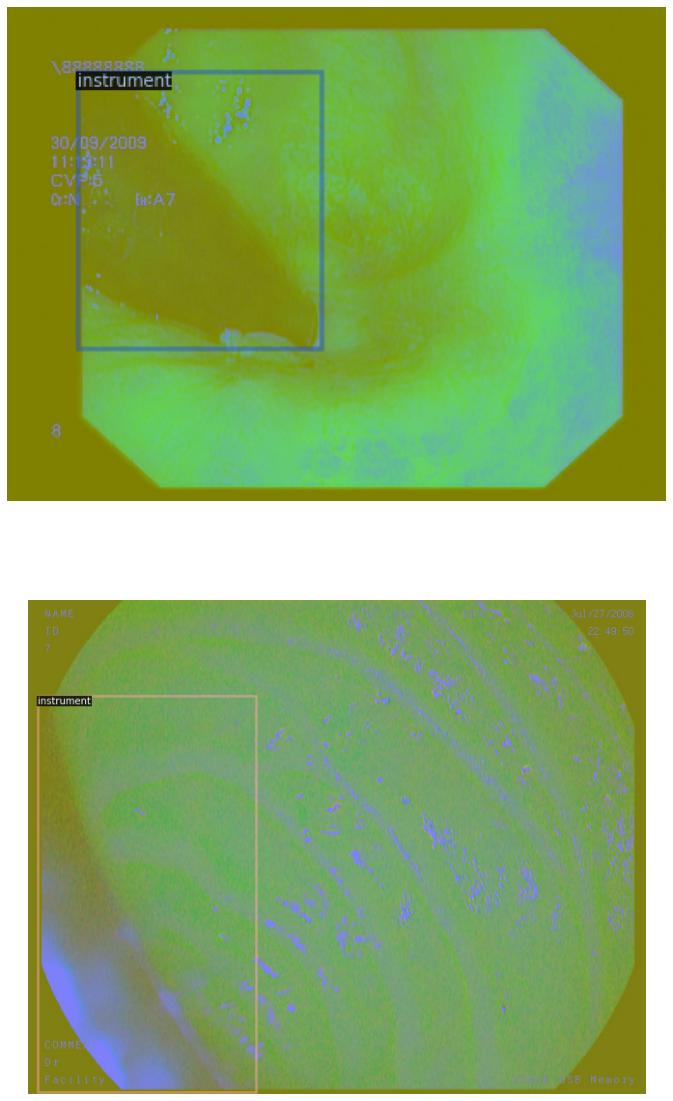

In [ ]:
fig, ax = plt.subplots(2, 1, figsize =(35,20))
i=-1
for d in random.sample(dataset_dicts_train, 2):
    i=i+1
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, :],
                   metadata=metadata_dicts_train,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].imshow(out.get_image()[:, :, ::-1])

In [ ]:
import logging
import numpy as np
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, cfg, model, data_loader):
        self._model = model
        self._period = cfg.TEST.EVAL_PERIOD
        self._root = cfg.OUTPUT_DIR
        self._data_loader = data_loader
        self._min_mean_loss = 0.0
        self._bfirst = True

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
        return mean_loss

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            if self._bfirst:
                self._min_mean_loss = mean_loss
                self._bfirst = False
            #-------- save best model according to metrics --------
            if mean_loss < self._min_mean_loss:
                self._min_mean_loss = mean_loss
                self.trainer.checkpointer.save('model_best')
                with open('bestiter.txt', 'a+') as f:
                    f.write('min val loss: ' + str(mean_loss) + ' at iter: ' + str(self.trainer.iter) + '\n')

In [ ]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name,("bbox",), True, output_folder)
        #return COCOEvaluator(dataset_name, cfg, True, output_folder)

        #return MAPIOUEvaluator(dataset_name)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [ ]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS ="../input/brdetectron2l/output/model_best.pth"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # 64 is slower but more accurate (128 faster but less accurate)


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # only has one class  + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 2 # only has one class  + 1

cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
cfg.SOLVER.GAMMA = 0.1


cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 800 #Maximum of iterations 1
cfg.SOLVER.STEPS = (200,400,750) #At which point to change the LR 0.25,0.5

cfg.TEST.EVAL_PERIOD = 60
#cfg.SOLVER.CHECKPOINT_PERIOD=100

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = AugTrainer(cfg) # with  data augmentation
trainer = Trainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[05/08 10:42:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 79/79 [00:00<00:00, 4737.29it/s]

[05/08 10:42:25 d2.data.build]: Removed 0 images with no usable annotations. 79 images left.
[05/08 10:42:25 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| instrument | 79           |
|            |              |
[05/08 10:42:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/08 10:42:25 d2.data.build]: Using training sampler TrainingSampler
[05/08 10:42:25 d2.data.common]: Serializing 79 elements to byte tensors and concatenating them all ...
[05/08 10:42:25 d2.data.common]: Serialized dataset takes 0.03 MiB


[05/08 10:42:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]


100%|██████████| 39/39 [00:00<00:00, 4752.96it/s]

[05/08 10:42:27 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
| instrument | 39           |
|            |              |
[05/08 10:42:27 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:42:27 d2.data.common]: Serialized dataset takes 0.02 MiB



model_final_280758.pkl: 167MB [00:03, 47.2MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_pr

[05/08 10:42:34 d2.engine.train_loop]: Starting training from iteration 0
[05/08 10:42:56 d2.utils.events]:  eta: 0:13:42  iter: 19  total_loss: 1.094  loss_cls: 0.4449  loss_box_reg: 0.5801  loss_rpn_cls: 0.01077  loss_rpn_loc: 0.004365  time: 1.0551  data_time: 0.0309  lr: 0.0005  max_mem: 2309M
[05/08 10:43:19 d2.utils.events]:  eta: 0:13:38  iter: 39  total_loss: 0.8094  loss_cls: 0.2423  loss_box_reg: 0.5625  loss_rpn_cls: 0.004282  loss_rpn_loc: 0.003125  time: 1.0848  data_time: 0.0082  lr: 0.0005  max_mem: 2309M


100%|██████████| 39/39 [00:00<00:00, 3814.16it/s]

[05/08 10:43:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:43:41 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:43:41 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:43:41 d2.evaluation.coco_evaluation]: Trying to convert 'BR_data_valid2' to COCO format ...
[05/08 10:43:41 d2.data.datasets.coco]: Converting annotations of dataset 'BR_data_valid2' to COCO format ...)



100%|██████████| 39/39 [00:00<00:00, 6618.30it/s]

[05/08 10:43:41 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/08 10:43:41 d2.data.datasets.coco]: Conversion finished, #images: 39, #annotations: 39
[05/08 10:43:41 d2.data.datasets.coco]: Caching COCO format annotations at './output/inference/BR_data_valid2_coco_format.json' ...
[05/08 10:43:41 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:43:45 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0021 s/iter. Inference: 0.3099 s/iter. Eval: 0.0004 s/iter. Total: 0.3123 s/iter. ETA=0:00:08
[05/08 10:43:50 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0028 s/iter. Inference: 0.3128 s/iter. Eval: 0.0004 s/iter. Total: 0.3163 s/iter. ETA=0:00:03
[05/08 10:43:54 d2.evaluation.evaluator]: Total inference time: 0:00:10.793026 (0.317442 s / iter per device, on 1 devices)
[05/08 10:43:54 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.312520 s / iter per device, on 1 devices)
[05/08 10:43:54 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:43:54 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:43:54 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:43:54 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3802.99it/s]

[05/08 10:45:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:45:10 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:45:10 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:45:10 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:45:13 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0019 s/iter. Inference: 0.3094 s/iter. Eval: 0.0003 s/iter. Total: 0.3116 s/iter. ETA=0:00:08
[05/08 10:45:18 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0023 s/iter. Inference: 0.3127 s/iter. Eval: 0.0003 s/iter. Total: 0.3156 s/iter. ETA=0:00:03
[05/08 10:45:22 d2.evaluation.evaluator]: Total inference time: 0:00:10.806988 (0.317853 s / iter per device, on 1 devices)
[05/08 10:45:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.313558 s / iter per device, on 1 devices)
[05/08 10:45:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:45:22 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:45:22 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:45:22 d2.ev

100%|██████████| 39/39 [00:00<00:00, 4024.85it/s]

[05/08 10:46:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:46:38 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:46:38 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:46:38 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:46:42 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0018 s/iter. Inference: 0.3095 s/iter. Eval: 0.0003 s/iter. Total: 0.3116 s/iter. ETA=0:00:08
[05/08 10:46:47 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0023 s/iter. Inference: 0.3115 s/iter. Eval: 0.0003 s/iter. Total: 0.3143 s/iter. ETA=0:00:03
[05/08 10:46:51 d2.evaluation.evaluator]: Total inference time: 0:00:10.728657 (0.315549 s / iter per device, on 1 devices)
[05/08 10:46:51 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.311224 s / iter per device, on 1 devices)
[05/08 10:46:51 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:46:51 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:46:51 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:46:51 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3982.61it/s]

[05/08 10:48:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:48:08 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:48:08 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:48:08 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:48:12 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0020 s/iter. Inference: 0.3072 s/iter. Eval: 0.0003 s/iter. Total: 0.3096 s/iter. ETA=0:00:08
[05/08 10:48:17 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0023 s/iter. Inference: 0.3122 s/iter. Eval: 0.0003 s/iter. Total: 0.3151 s/iter. ETA=0:00:03
[05/08 10:48:21 d2.evaluation.evaluator]: Total inference time: 0:00:10.755300 (0.316332 s / iter per device, on 1 devices)
[05/08 10:48:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.311805 s / iter per device, on 1 devices)
[05/08 10:48:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:48:21 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:48:21 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:48:21 d2.ev

100%|██████████| 39/39 [00:00<00:00, 7906.51it/s]

[05/08 10:49:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:49:38 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:49:38 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:49:38 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:49:42 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0017 s/iter. Inference: 0.3084 s/iter. Eval: 0.0003 s/iter. Total: 0.3104 s/iter. ETA=0:00:08
[05/08 10:49:47 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0023 s/iter. Inference: 0.3123 s/iter. Eval: 0.0003 s/iter. Total: 0.3152 s/iter. ETA=0:00:03
[05/08 10:49:50 d2.evaluation.evaluator]: Total inference time: 0:00:10.736284 (0.315773 s / iter per device, on 1 devices)
[05/08 10:49:50 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.311558 s / iter per device, on 1 devices)
[05/08 10:49:50 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:49:50 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:49:50 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:49:50 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3432.54it/s]

[05/08 10:51:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:51:08 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:51:08 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:51:08 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:51:11 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0029 s/iter. Inference: 0.3087 s/iter. Eval: 0.0003 s/iter. Total: 0.3118 s/iter. ETA=0:00:08
[05/08 10:51:16 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0023 s/iter. Inference: 0.3111 s/iter. Eval: 0.0003 s/iter. Total: 0.3139 s/iter. ETA=0:00:03
[05/08 10:51:20 d2.evaluation.evaluator]: Total inference time: 0:00:10.727725 (0.315521 s / iter per device, on 1 devices)
[05/08 10:51:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.311170 s / iter per device, on 1 devices)
[05/08 10:51:20 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:51:20 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:51:20 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:51:20 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3336.21it/s]

[05/08 10:52:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:52:34 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:52:34 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:52:34 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:52:38 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0020 s/iter. Inference: 0.3080 s/iter. Eval: 0.0003 s/iter. Total: 0.3103 s/iter. ETA=0:00:08
[05/08 10:52:43 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0025 s/iter. Inference: 0.3113 s/iter. Eval: 0.0003 s/iter. Total: 0.3143 s/iter. ETA=0:00:03
[05/08 10:52:47 d2.evaluation.evaluator]: Total inference time: 0:00:10.735277 (0.315743 s / iter per device, on 1 devices)
[05/08 10:52:47 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.311258 s / iter per device, on 1 devices)
[05/08 10:52:47 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:52:47 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:52:47 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:52:47 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3645.27it/s]

[05/08 10:54:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:54:03 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:54:03 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:54:03 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:54:07 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0016 s/iter. Inference: 0.3058 s/iter. Eval: 0.0003 s/iter. Total: 0.3077 s/iter. ETA=0:00:08
[05/08 10:54:12 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0022 s/iter. Inference: 0.3099 s/iter. Eval: 0.0003 s/iter. Total: 0.3126 s/iter. ETA=0:00:03
[05/08 10:54:15 d2.evaluation.evaluator]: Total inference time: 0:00:10.684724 (0.314257 s / iter per device, on 1 devices)
[05/08 10:54:15 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.310117 s / iter per device, on 1 devices)
[05/08 10:54:15 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:54:15 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:54:16 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:54:16 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3593.46it/s]

[05/08 10:55:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:55:31 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:55:31 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:55:31 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:55:34 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0018 s/iter. Inference: 0.3110 s/iter. Eval: 0.0003 s/iter. Total: 0.3132 s/iter. ETA=0:00:08
[05/08 10:55:39 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0023 s/iter. Inference: 0.3121 s/iter. Eval: 0.0003 s/iter. Total: 0.3148 s/iter. ETA=0:00:03
[05/08 10:55:43 d2.evaluation.evaluator]: Total inference time: 0:00:10.765546 (0.316634 s / iter per device, on 1 devices)
[05/08 10:55:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.312115 s / iter per device, on 1 devices)
[05/08 10:55:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:55:43 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:55:43 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:55:43 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3852.34it/s]

[05/08 10:56:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:56:57 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:56:57 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:56:57 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:57:00 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0020 s/iter. Inference: 0.3093 s/iter. Eval: 0.0003 s/iter. Total: 0.3116 s/iter. ETA=0:00:08
[05/08 10:57:06 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0030 s/iter. Inference: 0.3116 s/iter. Eval: 0.0003 s/iter. Total: 0.3151 s/iter. ETA=0:00:03
[05/08 10:57:09 d2.evaluation.evaluator]: Total inference time: 0:00:10.771314 (0.316803 s / iter per device, on 1 devices)
[05/08 10:57:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.312132 s / iter per device, on 1 devices)
[05/08 10:57:09 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:57:09 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:57:09 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:57:09 d2.ev

100%|██████████| 39/39 [00:00<00:00, 6312.34it/s]

[05/08 10:58:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:58:25 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:58:25 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:58:25 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:58:29 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0016 s/iter. Inference: 0.3056 s/iter. Eval: 0.0003 s/iter. Total: 0.3075 s/iter. ETA=0:00:08
[05/08 10:58:34 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0023 s/iter. Inference: 0.3108 s/iter. Eval: 0.0003 s/iter. Total: 0.3136 s/iter. ETA=0:00:03
[05/08 10:58:38 d2.evaluation.evaluator]: Total inference time: 0:00:10.715881 (0.315173 s / iter per device, on 1 devices)
[05/08 10:58:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.310911 s / iter per device, on 1 devices)
[05/08 10:58:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 10:58:38 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 10:58:38 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 10:58:38 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3171.90it/s]

[05/08 10:59:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 10:59:53 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 10:59:53 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 10:59:53 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 10:59:56 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0017 s/iter. Inference: 0.3052 s/iter. Eval: 0.0003 s/iter. Total: 0.3072 s/iter. ETA=0:00:08
[05/08 11:00:01 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0022 s/iter. Inference: 0.3112 s/iter. Eval: 0.0003 s/iter. Total: 0.3139 s/iter. ETA=0:00:03
[05/08 11:00:05 d2.evaluation.evaluator]: Total inference time: 0:00:10.716905 (0.315203 s / iter per device, on 1 devices)
[05/08 11:00:05 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.310825 s / iter per device, on 1 devices)
[05/08 11:00:05 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 11:00:05 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 11:00:05 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 11:00:05 d2.ev

100%|██████████| 39/39 [00:00<00:00, 3645.60it/s]

[05/08 11:01:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 11:01:20 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 11:01:20 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 11:01:20 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 11:01:24 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0021 s/iter. Inference: 0.3079 s/iter. Eval: 0.0003 s/iter. Total: 0.3104 s/iter. ETA=0:00:08
[05/08 11:01:29 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0024 s/iter. Inference: 0.3115 s/iter. Eval: 0.0003 s/iter. Total: 0.3143 s/iter. ETA=0:00:03
[05/08 11:01:33 d2.evaluation.evaluator]: Total inference time: 0:00:10.714445 (0.315131 s / iter per device, on 1 devices)
[05/08 11:01:33 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.310967 s / iter per device, on 1 devices)
[05/08 11:01:33 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 11:01:33 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 11:01:33 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 11:01:33 d2.ev

100%|██████████| 39/39 [00:00<00:00, 7750.30it/s]

[05/08 11:02:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/08 11:02:18 d2.data.common]: Serializing 39 elements to byte tensors and concatenating them all ...
[05/08 11:02:18 d2.data.common]: Serialized dataset takes 0.02 MiB
[05/08 11:02:18 d2.evaluation.evaluator]: Start inference on 39 batches


[05/08 11:02:22 d2.evaluation.evaluator]: Inference done 11/39. Dataloading: 0.0018 s/iter. Inference: 0.3062 s/iter. Eval: 0.0003 s/iter. Total: 0.3083 s/iter. ETA=0:00:08
[05/08 11:02:27 d2.evaluation.evaluator]: Inference done 27/39. Dataloading: 0.0023 s/iter. Inference: 0.3112 s/iter. Eval: 0.0003 s/iter. Total: 0.3139 s/iter. ETA=0:00:03
[05/08 11:02:30 d2.evaluation.evaluator]: Total inference time: 0:00:10.714463 (0.315131 s / iter per device, on 1 devices)
[05/08 11:02:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:10 (0.311040 s / iter per device, on 1 devices)
[05/08 11:02:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/08 11:02:30 d2.evaluation.coco_evaluation]: Saving results to ./output/inference/coco_instances_results.json
[05/08 11:02:30 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/08 11:02:31 d2.ev

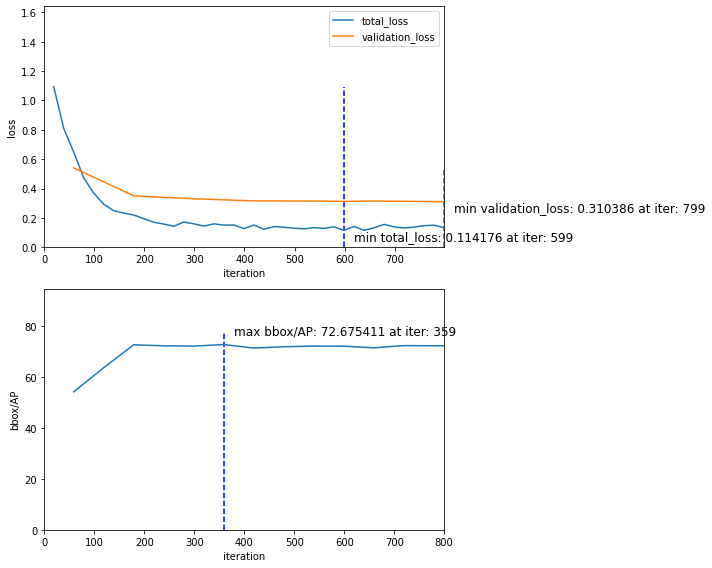

In [ ]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines
experiment_metrics = load_json_arr('./output/metrics.json')

iters_total_loss = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
total_loss = [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]


iters_validation_loss = [x['iteration'] for x in experiment_metrics if 'validation_loss' in x]
validation_loss = [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]

iters_AP = [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x]
AP = [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP' in x]

fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].plot(iters_total_loss, total_loss)
ax[0].plot(iters_validation_loss, validation_loss)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].legend(['total_loss', 'validation_loss'], loc='best')

iter = validation_loss.index(min(validation_loss))
ax[0].vlines(iters_validation_loss[iter], 0, float(max(validation_loss)),color="red",linestyles ="dashed")
ax[0].annotate('min validation_loss: %f at iter: %d'%(float(min(validation_loss)),int(iters_validation_loss[iter])),xy=(iters_validation_loss[iter],min(validation_loss)),xytext=(+10,-10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

iter = total_loss.index(min(total_loss))
ax[0].vlines(iters_total_loss[iter], 0, float(max(total_loss)),color="blue",linestyles ="dashed")
ax[0].annotate('min total_loss: %f at iter: %d'%(float(min(total_loss)),int(iters_total_loss[iter])),xy=(iters_total_loss[iter],min(total_loss)),xytext=(+10,-10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

ax[0].set_xlim([0,max(max(iters_total_loss),max(iters_validation_loss))])
ax[0].set_ylim([0,max(1.5*max(total_loss),1.5*max(validation_loss))])
#ax[0].legend(bbox_to_anchor=(1.0, 1.0))

ax[1].plot(iters_AP, AP)
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('bbox/AP')
iter = AP.index(max(AP))
ax[1].vlines(iters_AP[iter], 0, 5+float(max(AP)),color="blue",linestyles ="dashed")
ax[1].annotate('max bbox/AP: %f at iter: %d'%(float(max(AP)),int(iters_AP[iter])),xy=(iters_AP[iter],max(AP)),xytext=(+10,+10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')
ax[1].set_xlim([0,max(iters_AP)])
ax[1].set_ylim([0,max(AP)*1.3])

fig.tight_layout()
plt.show()

[05/08 11:04:04 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

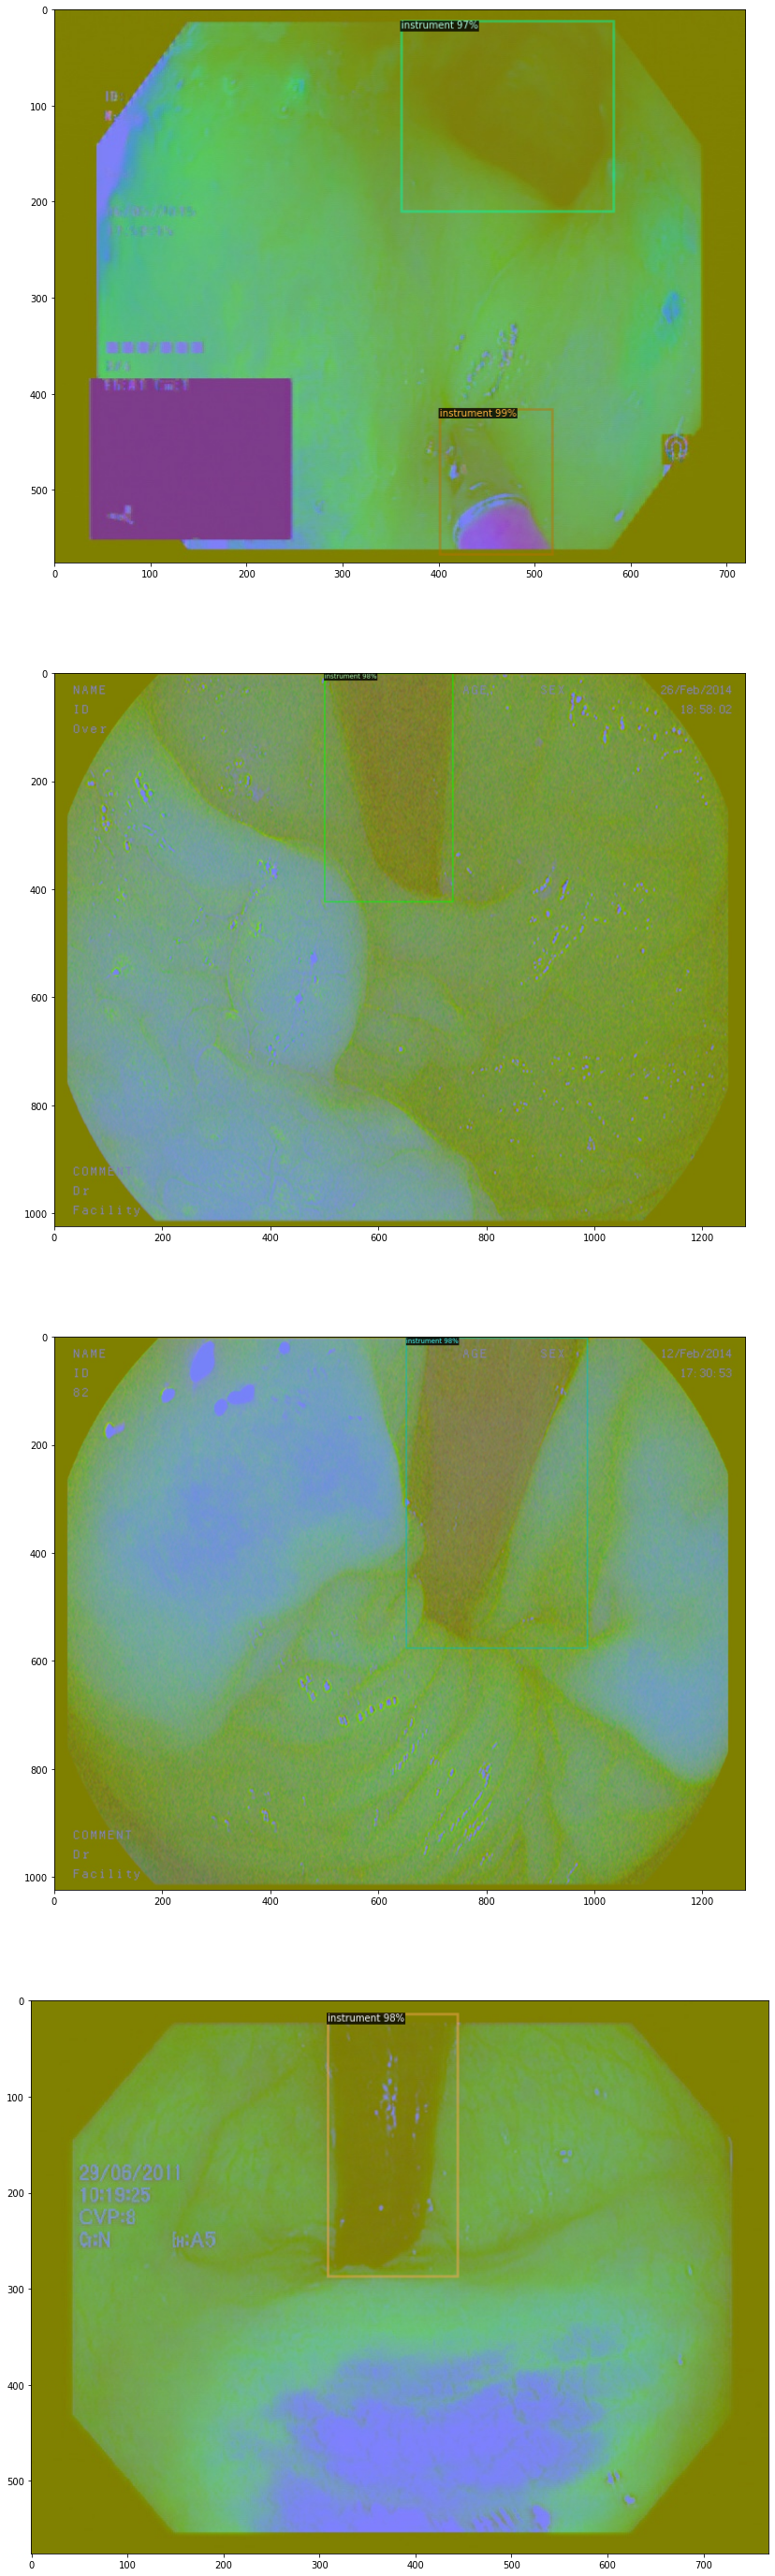

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold for this model
cfg.DATASETS.TEST = (Data_Resister_valid, )
predictor = DefaultPredictor(cfg)

fig, ax = plt.subplots(4, 1, figsize =(20,50))
indices=[ax[0],ax[1],ax[2],ax[3] ]
i=-1
for d in random.sample(dataset_dicts_valid, 4):
    i=i+1
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, :],
                   metadata=metadata_dicts_valid,
                   scale=1 # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])